# Brain tumor segmentation

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 132.0 MB/s 


In [ ]:
!pip install pyradiomics # required package for extracting radiomics features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188 kB 4.7 MB/s 
     |████████████████████████████████| 109 kB 64.1 MB/s 
     |████████████████████████████████| 500 kB 53.6 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=8754374e6c52c0c6000b3fb8696eaa7a0d33728f3405f6c9a61cc367bc627766
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import glob
import datetime
import splitfolders
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import warnings
import SimpleITK as sitk
from IPython.display import Image
warnings.filterwarnings('ignore')

## Load dataset

In [ ]:
! gdown --id 10xILW1Eu4AnZ9ml4Xmn-OLvMmV4zse4A

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10xILW1Eu4AnZ9ml4Xmn-OLvMmV4zse4A
To: /content/files.rar
100% 113k/113k [00:00<00:00, 90.0MB/s]


In [ ]:
! unrar  x -Y  '/content/files.rar' -C '/content/'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/files.rar

Extracting  /content/model.py                                              1%  OK 
Extracting  /content/planes.jpg                                           22%  OK 
Extracting  /content/unet.png                                             96%  OK 
Extracting  /content/dice.png                                             99%  OK 
All OK


In [ ]:
! gdown --id 17CaURkK4ItQVkI-CxE2opsmradRxTAoR

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17CaURkK4ItQVkI-CxE2opsmradRxTAoR
To: /content/Copy of Task01_BrainTumour.tar
100% 7.61G/7.61G [00:47<00:00, 160MB/s]


In [ ]:
! tar -xvf  '/content/Copy of Task01_BrainTumour.tar' -C '/content/'

Task01_BrainTumour/._dataset.json
Task01_BrainTumour/dataset.json
Task01_BrainTumour/._imagesTr
Task01_BrainTumour/imagesTr/
Task01_BrainTumour/imagesTr/BRATS_457.nii.gz
Task01_BrainTumour/imagesTr/BRATS_306.nii.gz
Task01_BrainTumour/imagesTr/BRATS_206.nii.gz
Task01_BrainTumour/imagesTr/BRATS_449.nii.gz
Task01_BrainTumour/imagesTr/BRATS_318.nii.gz
Task01_BrainTumour/imagesTr/BRATS_218.nii.gz
Task01_BrainTumour/imagesTr/BRATS_434.nii.gz
Task01_BrainTumour/imagesTr/BRATS_365.nii.gz
Task01_BrainTumour/imagesTr/BRATS_265.nii.gz
Task01_BrainTumour/imagesTr/BRATS_214.nii.gz
Task01_BrainTumour/imagesTr/BRATS_314.nii.gz
Task01_BrainTumour/imagesTr/BRATS_445.nii.gz
Task01_BrainTumour/imagesTr/BRATS_269.nii.gz
Task01_BrainTumour/imagesTr/BRATS_369.nii.gz
Task01_BrainTumour/imagesTr/BRATS_438.nii.gz
Task01_BrainTumour/imagesTr/BRATS_277.nii.gz
Task01_BrainTumour/imagesTr/BRATS_377.nii.gz
Task01_BrainTumour/imagesTr/BRATS_426.nii.gz
Task01_BrainTumour/imagesTr/BRATS_095.nii.gz
Task01_BrainTumour/i

## Train/Val/Test Split

In [ ]:
!rm -rf "/content/Copy of Task01_BrainTumour.tar"
!rm -rf "/content/Task01_BrainTumour/imagesTs"
!rm "/content/Task01_BrainTumour/dataset.json"

In [ ]:
# Split with a ratio.
splitfolders.ratio("/content/Task01_BrainTumour", output="/content/data",
                   seed=816, ratio=(.85, .075, .075),
                   group_prefix=None)

Copying files: 968 files [00:10, 89.53 files/s]  


In [ ]:
!rm -rf "/content/Task01_BrainTumour"

## read and plot images

In [ ]:
def read_image_nii(image_path):
  return np.array(nib.load(image_path).get_fdata())

In [ ]:
img1 = read_image_nii("/content/data/train/imagesTr/BRATS_009.nii.gz")
img1 = np.rot90(img1[..., [0,2]])
img1_label = np.rot90(np.array(nib.load("/content/data/train/labelsTr/BRATS_009.nii.gz").dataobj))
img2 = read_image_nii("/content/data/train/imagesTr/BRATS_012.nii.gz")
img2 = np.rot90(img2[..., [0,2]])
img2_label = np.rot90(np.array(nib.load("/content/data/train/labelsTr/BRATS_012.nii.gz").dataobj))

In [ ]:
print(img1.shape)
print(img2.shape)

(240, 240, 155, 2)
(240, 240, 155, 2)


In [ ]:
print(img1_label.shape)
print(img2_label.shape)

(240, 240, 155)
(240, 240, 155)


In [ ]:
def plot_image(img, label, slice_num = 120):
  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(img[slice_num,:,:,0])
  axs[0].set_title("MRI, Slice #{}".format(slice_num))

  axs[1].imshow(label[slice_num,:,:])
  axs[1].set_title("Tumor, Slice #{}".format(slice_num))

  fig.tight_layout()

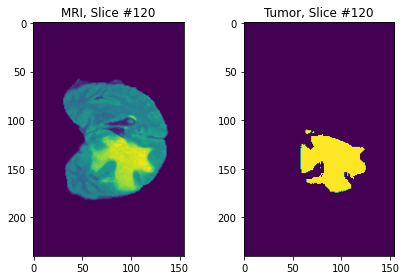

In [ ]:
plot_image(img1, img1_label)

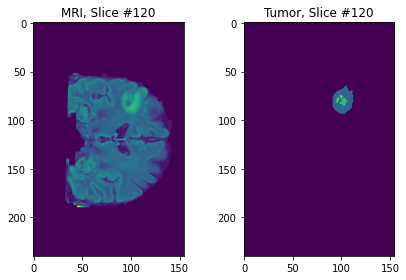

In [ ]:
plot_image(img2, img2_label)

## Exploring dataset

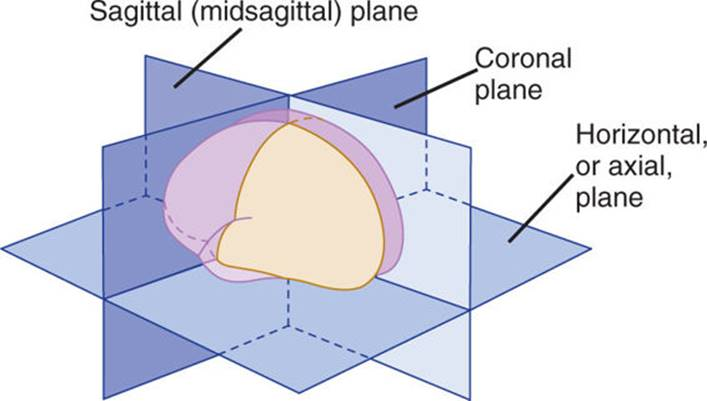

In [ ]:
Image(filename="/content/planes.jpg")

In [ ]:
image_norm = cv2.normalize(img1[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)
image_norm.shape

(240, 240, 155)

In [ ]:
data_all=[image_norm]
# coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 0])
coronal = np.rot90(coronal, 1)
print(coronal.shape)
# transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)
print(transversal.shape)
(240, 240, 155, 3, 1)
# sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 0])
sagittal = np.rot90(sagittal, 1)
print(sagittal.shape)

(155, 240, 240, 1)
(240, 240, 155, 1)
(155, 240, 240, 1)


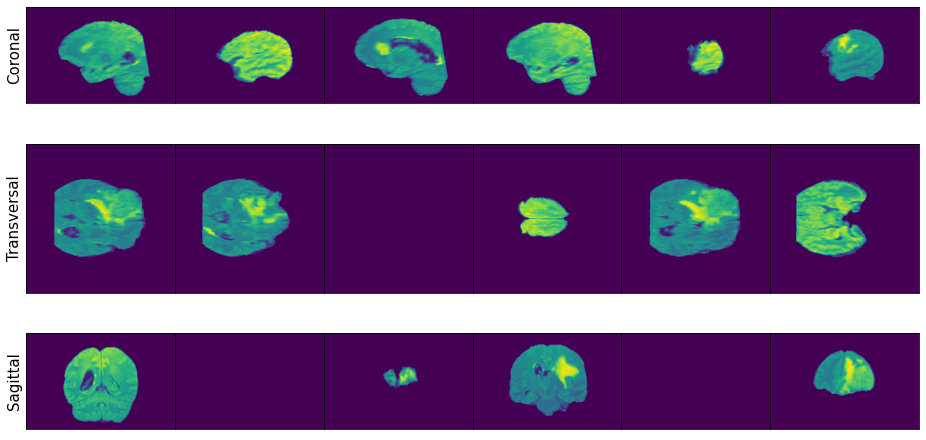

In [ ]:
fig, ax = plt.subplots(3, 6, figsize=[16, 9])

for i in range(6):
    n = np.random.randint(coronal.shape[2])
    ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('Coronal', fontsize=15)

for i in range(6):
    n = np.random.randint(transversal.shape[2])
    ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('Transversal', fontsize=15)

for i in range(6):
    n = np.random.randint(sagittal.shape[2])
    ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('Sagittal', fontsize=15)

fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
@interact
def explore_3dimage(layer = (0,154) , modality=['t1', 't2', 't1ce', 'flair'] , view = ['axial' , 'sagittal' , 'coronal']):
    array_view = read_image_nii("/content/data/train/imagesTr/BRATS_142.nii.gz")

    if modality == 't1':
      modal = 1
    elif modality == 't2':
      modal = 3
    elif modality == 't1ce':
      modal = 2
    elif modality == 'flair':
      modal = 0
    else :
      print("Error")

    if view == 'axial':
      array_view = array_view[layer, :,:, modal]
    elif view == 'coronal':
      array_view = array_view[:, layer, :, modal]
    elif view == 'sagittal':
      array_view = array_view[:, : ,layer, modal]
    else:
      print("Error")

    plt.figure(figsize=(10, 5))
    plt.imshow(array_view)
    plt.title('Explore Layers of Brain', fontsize=10)
    plt.axis('off')

interactive(children=(IntSlider(value=77, description='layer', max=154), Dropdown(description='modality', opti…

## Cropping

In [ ]:
from radiomics import featureextractor
import six

In [ ]:
def centre_of_tumor(input_image,input_mask):
  input_image = sitk.GetImageFromArray(input_image)
  input_mask = sitk.GetImageFromArray(input_mask)

  extractor = featureextractor.RadiomicsFeatureExtractor()
  extractor.disableAllFeatures()

  result = extractor.execute(input_image,input_mask)

  centre_of_mass = []
  for key, value in six.iteritems(result):
    if key == 'diagnostics_Mask-original_CenterOfMassIndex':
      centre_of_mass.append(value[0])
      centre_of_mass.append(value[1])
      centre_of_mass.append(value[2])
  return centre_of_mass

In [ ]:
def crop_images(img,centre_of_mass):

  optimal_roi = [144,144,144]
  image_size = [240,240,155]

  x_roi = round(optimal_roi[0]/2)
  y_roi = round(optimal_roi[1]/2)
  z_roi = round(optimal_roi[2]/2)
  x_centre = round(centre_of_mass[0])
  y_centre = round(centre_of_mass[1])
  z_centre= round(centre_of_mass[2])

  if x_centre - x_roi< 0:
    start_x = 0
    end_x = optimal_roi[0]
  elif x_centre + x_roi > image_size[0]:
    end_x = image_size[0]
    start_x = end_x - optimal_roi[0]
  else:
    start_x = x_centre - x_roi
    end_x =  x_centre + x_roi

  if y_centre - y_roi< 0:
    start_y = 0
    end_y = optimal_roi[1]
  elif y_centre + y_roi > image_size[1]:
    end_y = image_size[1]
    start_y = end_y - optimal_roi[1]
  else:
    start_y = y_centre - y_roi
    end_y =  y_centre + y_roi

  if z_centre - z_roi< 0:
    start_z = 0
    end_z = optimal_roi[2]
  elif z_centre + z_roi > image_size[2]:
    end_z = image_size[2]
    start_z = end_z - optimal_roi[2]
  else:
    start_z = z_centre - z_roi
    end_z =  z_centre + z_roi

  cropped_img = img[start_x:end_x,
                    start_y:end_y,
                    start_z:end_z]

  return cropped_img

In [ ]:
centre1 = centre_of_tumor(img1[:,:,:,0],img1_label)
centre2 = centre_of_tumor(img2[:,:,:,0],img2_label)

img1_after_crop = crop_images(img1,centre1)
img1_label_after_crop = crop_images(img1_label,centre1)
img2_after_crop = crop_images(img2,centre2)
img2_label_after_crop = crop_images(img2_label,centre2)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimension

In [ ]:
print(img1_after_crop.shape)
print(img2_after_crop.shape)

In [ ]:
print(img1_label_after_crop.shape)
print(img2_label_after_crop.shape)

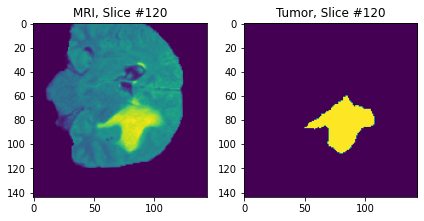

In [ ]:
plot_image(img1_after_crop, img1_label_after_crop)

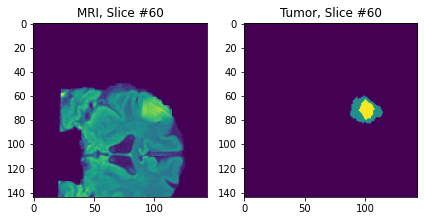

In [ ]:
plot_image(img2_after_crop, img2_label_after_crop,60)

## Normalization + Label merging

In [ ]:
def preprocess_img(img):
  """
  Normalize the image so that the mean value for each image
  is 0 and the standard deviation is 1.
  """
  for channel in range(img.shape[-1]):
    img_temp = img[..., channel]
    img_temp = (img_temp - np.mean(img_temp)) / np.std(img_temp)
    img[..., channel] = img_temp
  return img

In [ ]:
def preprocess_label(label):
    """
    Predict whole tumor.
    """
    label[label > 0] = 1.0
    label = np.expand_dims(label, -1)
    return label

In [ ]:
img1_after_preprocess = preprocess_img(img1_after_crop)
img1_label_after_preprocess =  preprocess_label(img1_label_after_crop)
img2_after_preprocess = preprocess_img(img2_after_crop)
img2_label_after_preprocess =  preprocess_label(img2_label_after_crop)

In [ ]:
def plot_image(img, label, slice_num = 120):
  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(img[slice_num,:,:,0])
  axs[0].set_title("MRI, Slice #{}".format(slice_num))

  axs[1].imshow(label[slice_num,:,:,0])
  axs[1].set_title("Tumor, Slice #{}".format(slice_num))

  fig.tight_layout()

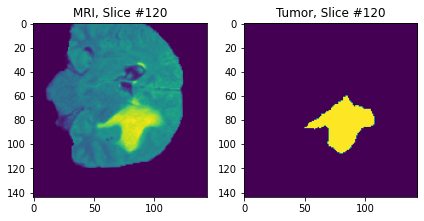

In [ ]:
plot_image(img1_after_preprocess, img1_label_after_preprocess)

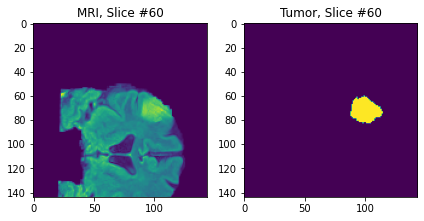

In [ ]:
plot_image(img2_after_preprocess, img2_label_after_preprocess, 60)

## Apply preprocessing on all train and val files

In [ ]:
train_image_list = sorted(glob.glob('/content/data/train/imagesTr/BRATS_*.nii.gz'))
train_mask_list = sorted(glob.glob('/content/data/train/labelsTr/BRATS_*.nii.gz'))

print(train_image_list)
print(train_mask_list)

['/content/data/train/imagesTr/BRATS_001.nii.gz', '/content/data/train/imagesTr/BRATS_002.nii.gz', '/content/data/train/imagesTr/BRATS_003.nii.gz', '/content/data/train/imagesTr/BRATS_004.nii.gz', '/content/data/train/imagesTr/BRATS_005.nii.gz', '/content/data/train/imagesTr/BRATS_006.nii.gz', '/content/data/train/imagesTr/BRATS_008.nii.gz', '/content/data/train/imagesTr/BRATS_009.nii.gz', '/content/data/train/imagesTr/BRATS_010.nii.gz', '/content/data/train/imagesTr/BRATS_011.nii.gz', '/content/data/train/imagesTr/BRATS_012.nii.gz', '/content/data/train/imagesTr/BRATS_013.nii.gz', '/content/data/train/imagesTr/BRATS_014.nii.gz', '/content/data/train/imagesTr/BRATS_015.nii.gz', '/content/data/train/imagesTr/BRATS_016.nii.gz', '/content/data/train/imagesTr/BRATS_017.nii.gz', '/content/data/train/imagesTr/BRATS_018.nii.gz', '/content/data/train/imagesTr/BRATS_020.nii.gz', '/content/data/train/imagesTr/BRATS_022.nii.gz', '/content/data/train/imagesTr/BRATS_023.nii.gz', '/content/data/trai

In [ ]:
os.mkdir("/content/data/train_preprocessed")
os.mkdir("/content/data/train_preprocessed/images/")
os.mkdir("/content/data/train_preprocessed/masks/")

In [ ]:
# apply preprocessing on all
for i in range(len(train_image_list)):
    print("Now preparing image and masks number: ", i)

    image_path = train_image_list[i]
    mask_path = train_mask_list[i]

    img = read_image_nii(image_path)
    img = np.rot90(img[..., [0,2]]) # Just take t1c, t2, and FLAIR channels
    label = np.rot90(np.array(nib.load(mask_path).dataobj))

    #preprocess
    centre = centre_of_tumor(img[:,:,:,0], label[:,:,:])
    img = crop_images(img, centre)
    label = crop_images(label, centre)
    img = preprocess_img(img)
    label = preprocess_label(label)

    np.save('/content/data/train_preprocessed/images/image_'+str(i)+'.npy', img)
    np.save('/content/data/train_preprocessed/masks/mask_'+str(i)+'.npy', label)


Now preparing image and masks number:  0


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  1


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  2


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  3


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  4


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  5


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  6


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  7


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  8


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  9


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  10


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  11


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  12


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  13


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  14


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  15


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  16


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  17


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  18


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  19


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  20


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  21


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  22


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  23


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  24


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  25


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  26


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  27


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  28


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  29


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  30


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  31


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  32


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  33


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  34


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  35


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  36


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  37


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  38


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  39


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  40


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  41


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  42


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  43


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  44


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  45


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  46


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  47


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  48


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  49


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  50


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  51


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  52


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  53


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  54


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  55


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  56


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  57


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  58


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  59


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  60


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  61


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  62


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  63


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  64


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  65


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  66


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  67


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  68


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  69


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  70


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  71


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  72


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  73


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  74


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  75


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  76


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  77


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  78


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  79


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  80


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  81


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  82


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  83


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  84


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  85


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  86


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  87


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  88


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  89


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  90


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  91


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  92


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  93


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  94


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  95


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  96


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  97


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  98


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  99


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  100


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  101


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  102


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  103


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  104


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  105


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  106


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  107


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  108


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  109


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  110


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  111


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  112


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  113


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  114


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  115


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  116


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  117


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  118


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  119


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  120


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  121


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  122


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  123


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  124


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  125


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  126


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  127


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  128


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  129


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  130


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  131


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  132


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  133


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  134


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  135


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  136


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  137


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  138


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  139


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  140


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  141


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  142


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  143


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  144


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  145


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  146


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  147


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  148


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  149


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  150


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  151


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  152


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  153


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  154


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  155


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  156


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  157


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  158


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  159


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  160


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  161


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  162


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  163


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  164


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  165


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  166


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  167


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  168


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  169


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  170


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  171


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  172


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  173


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  174


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  175


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  176


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  177


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  178


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  179


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  180


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  181


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  182


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  183


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  184


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  185


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  186


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  187


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  188


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  189


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  190


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  191


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  192


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  193


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  194


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  195


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  196


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  197


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  198


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  199


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  200


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  201


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  202


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  203


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  204


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  205


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  206


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  207


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  208


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  209


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  210


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  211


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  212


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  213


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  214


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  215


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  216


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  217


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  218


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  219


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  220


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  221


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  222


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  223


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  224


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  225


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  226


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  227


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  228


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  229


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  230


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  231


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  232


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  233


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  234


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  235


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  236


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  237


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  238


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  239


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  240


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  241


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  242


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  243


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  244


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  245


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  246


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  247


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  248


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  249


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  250


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  251


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  252


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  253


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  254


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  255


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  256


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  257


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  258


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  259


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  260


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  261


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  262


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  263


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  264


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  265


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  266


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  267


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  268


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  269


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  270


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  271


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  272


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  273


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  274


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  275


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  276


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  277


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  278


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  279


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  280


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  281


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  282


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  283


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  284


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  285


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  286


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  287


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  288


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  289


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  290


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  291


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  292


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  293


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  294


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  295


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  296


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  297


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  298


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  299


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  300


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  301


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  302


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  303


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  304


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  305


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  306


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  307


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  308


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  309


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  310


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  311


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  312


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  313


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  314


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  315


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  316


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  317


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  318


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  319


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  320


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  321


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  322


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  323


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  324


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  325


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  326


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  327


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  328


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  329


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  330


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  331


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  332


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  333


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  334


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  335


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  336


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  337


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  338


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  339


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  340


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  341


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  342


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  343


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  344


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  345


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  346


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  347


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  348


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  349


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  350


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  351


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  352


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  353


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  354


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  355


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  356


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  357


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  358


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  359


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  360


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  361


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  362


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  363


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  364


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  365


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  366


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  367


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  368


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  369


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  370


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  371


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  372


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  373


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  374


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  375


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  376


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  377


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  378


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  379


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  380


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  381


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  382


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  383


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  384


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  385


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  386


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  387


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  388


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  389


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  390


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  391


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  392


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  393


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  394


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  395


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  396


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  397


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  398


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  399


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  400


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  401


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  402


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  403


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  404


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  405


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  406


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  407


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  408


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  409


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  410


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


In [ ]:
val_image_list = sorted(glob.glob('/content/data/val/imagesTr/BRATS_*.nii.gz'))
val_mask_list = sorted(glob.glob('/content/data/val/labelsTr/BRATS_*.nii.gz'))

print(val_image_list)
print(val_mask_list)

['/content/data/val/imagesTr/BRATS_007.nii.gz', '/content/data/val/imagesTr/BRATS_052.nii.gz', '/content/data/val/imagesTr/BRATS_067.nii.gz', '/content/data/val/imagesTr/BRATS_094.nii.gz', '/content/data/val/imagesTr/BRATS_100.nii.gz', '/content/data/val/imagesTr/BRATS_119.nii.gz', '/content/data/val/imagesTr/BRATS_136.nii.gz', '/content/data/val/imagesTr/BRATS_147.nii.gz', '/content/data/val/imagesTr/BRATS_148.nii.gz', '/content/data/val/imagesTr/BRATS_160.nii.gz', '/content/data/val/imagesTr/BRATS_187.nii.gz', '/content/data/val/imagesTr/BRATS_190.nii.gz', '/content/data/val/imagesTr/BRATS_218.nii.gz', '/content/data/val/imagesTr/BRATS_224.nii.gz', '/content/data/val/imagesTr/BRATS_226.nii.gz', '/content/data/val/imagesTr/BRATS_259.nii.gz', '/content/data/val/imagesTr/BRATS_273.nii.gz', '/content/data/val/imagesTr/BRATS_297.nii.gz', '/content/data/val/imagesTr/BRATS_306.nii.gz', '/content/data/val/imagesTr/BRATS_309.nii.gz', '/content/data/val/imagesTr/BRATS_317.nii.gz', '/content/da

In [ ]:
os.mkdir("/content/data/val_preprocessed")
os.mkdir("/content/data/val_preprocessed/images/")
os.mkdir("/content/data/val_preprocessed/masks/")

In [ ]:
# apply preprocessing on all
for i in range(len(val_image_list)):
    print("Now preparing image and masks number: ", i)

    image_path = val_image_list[i]
    mask_path = val_mask_list[i]

    img = read_image_nii(image_path)
    img = np.rot90(img[..., [0,2]]) # Just take t1c, t2, and FLAIR channels
    label = np.rot90(np.array(nib.load(mask_path).dataobj))

    #preprocess
    centre = centre_of_tumor(img[:,:,:,0], label[:,:,:])
    img = crop_images(img, centre)
    label = crop_images(label, centre)
    img = preprocess_img(img)
    label = preprocess_label(label)

    np.save('/content/data/val_preprocessed/images/image_'+str(i)+'.npy', img)
    np.save('/content/data/val_preprocessed/masks/mask_'+str(i)+'.npy', label)


Now preparing image and masks number:  0


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  1


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  2


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  3


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  4


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  5


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  6


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  7


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  8


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  9


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  10


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  11


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  12


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  13


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  14


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  15


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  16


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  17


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  18


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  19


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  20


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  21


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  22


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  23


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  24


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  25


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  26


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  27


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  28


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  29


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  30


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  31


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  32


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  33


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  34


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


Now preparing image and masks number:  35


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image


In [ ]:
!rm -rf "/content/data/train"
!rm -rf "/content/data/val"

## Build Res-Unet model

### Create dataset generator

In [ ]:
! gdown --id 1uEtYVUwzHdvCxE_jjnxFoenM5tQBX-hy
! unzip  '/content/data.zip' -d '/'
!rm "/content/data.zip"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1uEtYVUwzHdvCxE_jjnxFoenM5tQBX-hy
To: /content/data.zip
100% 2.40G/2.40G [00:21<00:00, 112MB/s]
Archive:  /content/data.zip
   creating: /content/data/
   creating: /content/data/train_preprocessed/
   creating: /content/data/train_preprocessed/masks/
  inflating: /content/data/train_preprocessed/masks/mask_180.npy  
  inflating: /content/data/train_preprocessed/masks/mask_205.npy  
  inflating: /content/data/train_preprocessed/masks/mask_275.npy  
  inflating: /content/data/train_preprocessed/masks/mask_117.npy  
  inflating: /content/data/train_preprocessed/masks/mask_144.npy  
  inflating: /content/data/train_preprocessed/masks/mask_92.npy  
  inflating: /content/data/train_preprocessed/masks/mask_44.npy  
  inf

In [ ]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)

In [ ]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit]).astype(np.float32)
            Y = load_img(mask_dir, mask_list[batch_start:limit]).astype(np.float32)

            yield (X,Y)

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
train_img_dir = "/content/data/train_preprocessed/images/"
train_mask_dir = "/content/data/train_preprocessed/masks/"
train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

batch_size = 3

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

In [ ]:
img, msk = train_img_datagen.__next__()
print(img.shape)
print(msk.shape)

(3, 144, 144, 144, 2)
(3, 144, 144, 144, 1)


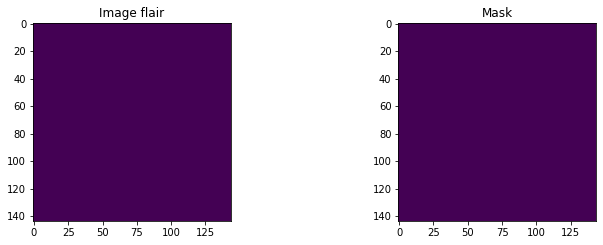

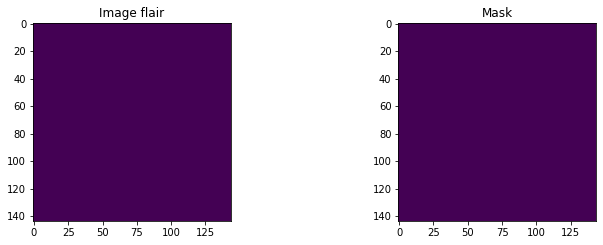

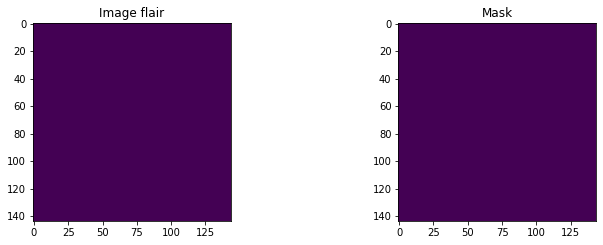

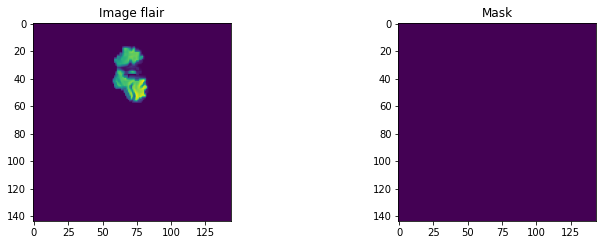

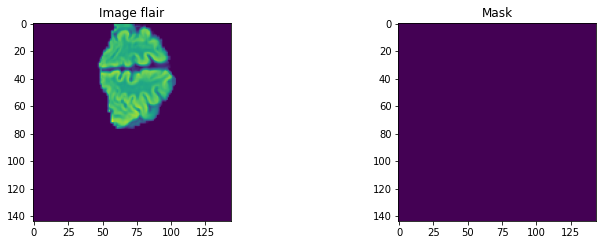

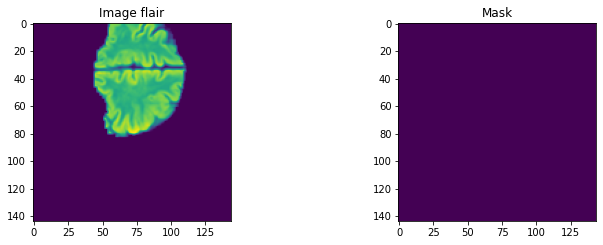

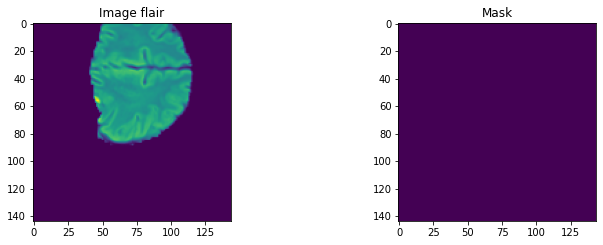

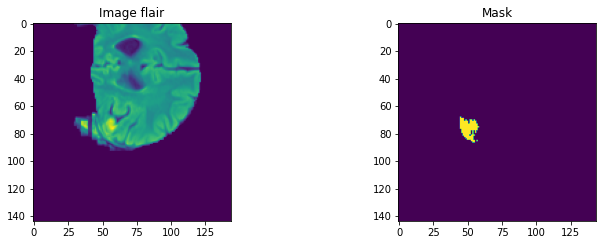

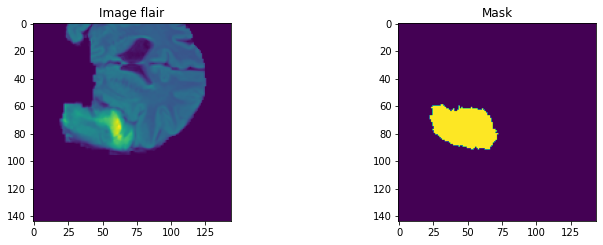

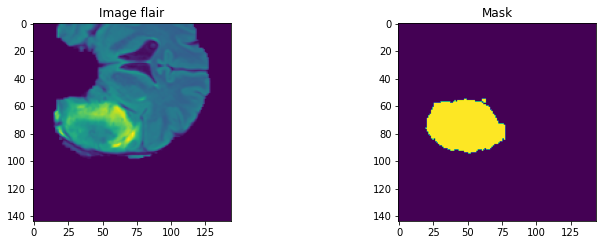

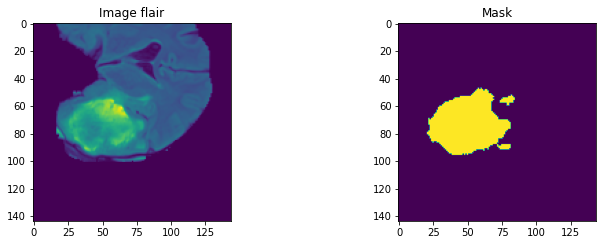

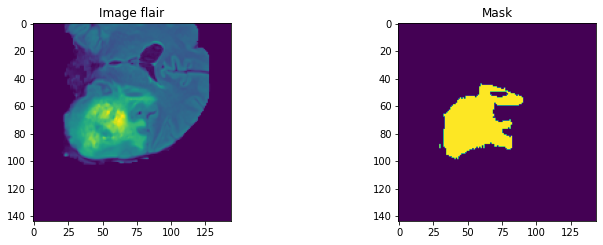

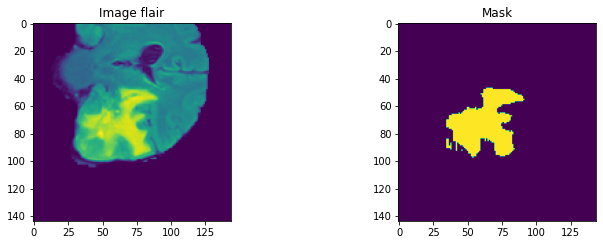

In [ ]:
img_num = 0

test_img=img[img_num]
test_mask=msk[img_num]

for i in range(10,140,10):
  n_slice=i
  plt.figure(figsize=(12, 8))

  plt.subplot(221)
  plt.imshow(test_img[n_slice,:,:,0])
  plt.title('Image flair')
  plt.subplot(222)
  plt.imshow(test_mask[n_slice,:,:,0])
  plt.title('Mask')
  plt.show()

In [ ]:
val_img_dir = "/content/data/val_preprocessed/images/"
val_mask_dir = "/content/data/val_preprocessed/masks/"
val_img_list= sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
img, msk = val_img_datagen.__next__()
print(img.shape)
print(msk.shape)

(3, 144, 144, 144, 2)
(3, 144, 144, 144, 1)


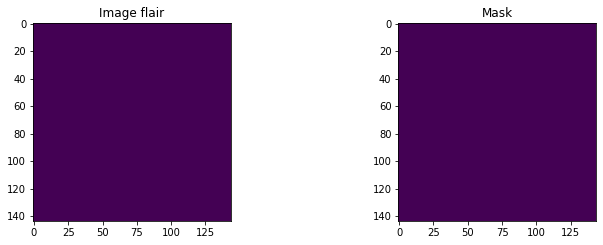

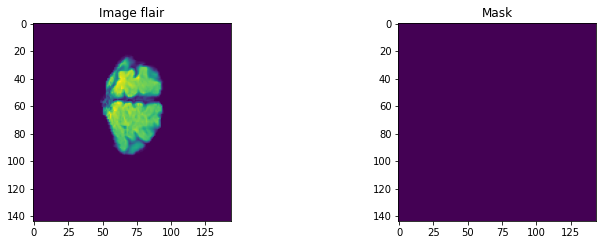

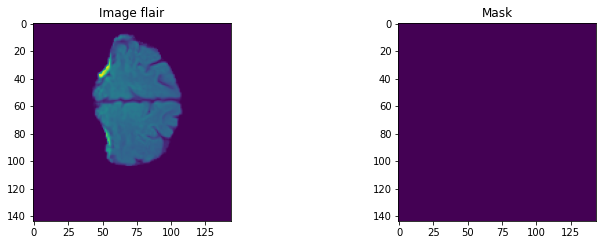

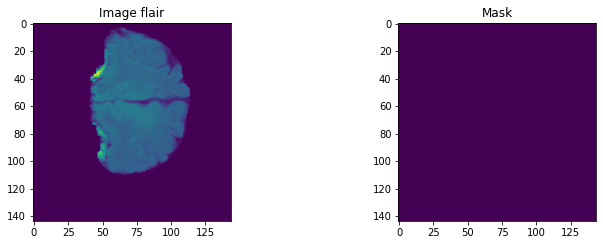

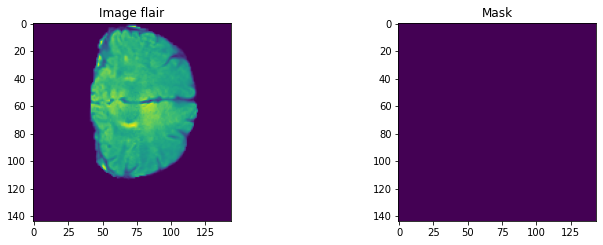

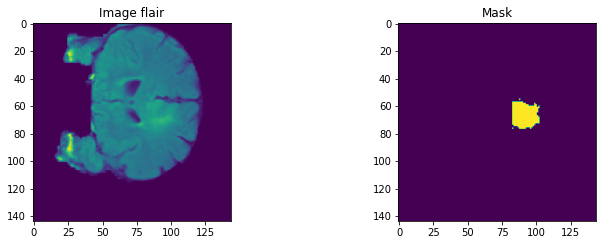

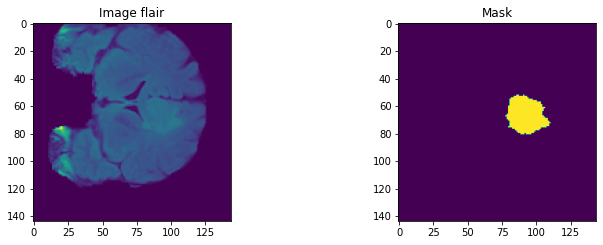

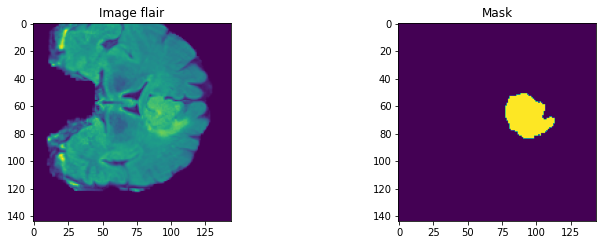

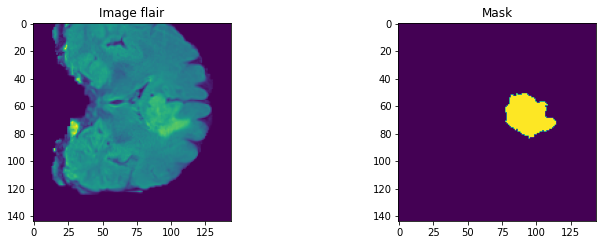

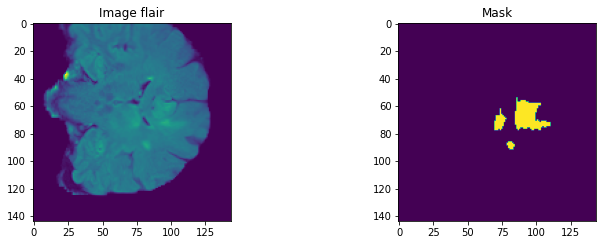

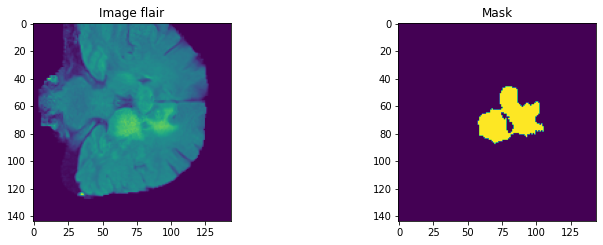

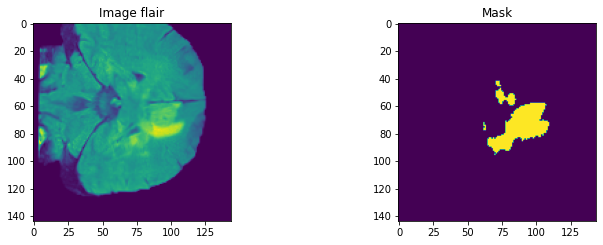

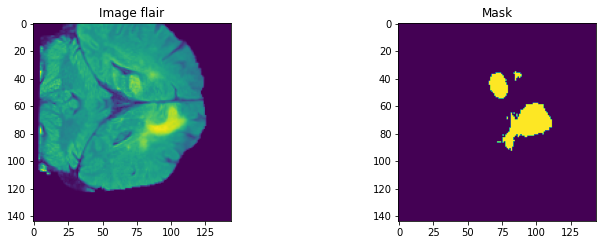

In [ ]:
img_num = 0

test_img=img[img_num]
test_mask=msk[img_num]

for i in range(10,140,10):
  n_slice=i
  plt.figure(figsize=(12, 8))

  plt.subplot(221)
  plt.imshow(test_img[n_slice,:,:,0])
  plt.title('Image flair')
  plt.subplot(222)
  plt.imshow(test_mask[n_slice,:,:,0])
  plt.title('Mask')
  plt.show()

### Define the model

In [ ]:
%load Res_Unet.py

In [ ]:
from Res_Unet import aru_gd, dice_coef, soft_dice_coef, dice_loss
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
input_shape = (144,144,144,2)

model = aru_gd(input_shape)

filepath="/content/ARUGD_training_checkpoint.h5"

checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='loss',verbose=1, mode='min', period=1)

In [ ]:
print(model.input_shape)
print(model.output_shape)

(None, 144, 144, 144, 2)
(None, 144, 144, 144, 1)


In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss= dice_loss, metrics=[dice_coef, soft_dice_coef])

model.summary()

Model: "res_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 1  0           []                               
                                44, 2)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 144, 144, 14  1760        ['input_1[0][0]']                
                                4, 32)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 144, 144, 14  128        ['conv3d[0][0]']                 
 alization)                     4, 32)                                               

### Train the model

In [ ]:
start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

steps_per_epoch = len(train_img_list)// batch_size
validation_steps = len(val_img_list) // batch_size

model.fit(train_img_datagen, epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_img_datagen,
          validation_steps = validation_steps,
          callbacks=checkpoint,
          verbose=1)

print("Total time elapsed for training = {} seconds".format(datetime.datetime.now() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))

Training started at 2022-10-25 20:12:38.174579
Epoch 1/10
137/137 [==============================] - ETA: 0s - loss: 0.9070 - dice_coef: 0.5409 - soft_dice_coef: 0.4898
Epoch 1: saving model to /content/ARUGD_training_checkpoint.h5
137/137 [==============================] - 217s 1s/step - loss: 0.9070 - dice_coef: 0.5409 - soft_dice_coef: 0.4898 - val_loss: 2.0824 - val_dice_coef: 0.1439 - val_soft_dice_coef: 0.1408
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.2861 - dice_coef: 0.7625 - soft_dice_coef: 0.7595
Epoch 2: saving model to /content/ARUGD_training_checkpoint.h5
137/137 [==============================] - 189s 1s/step - loss: 0.2861 - dice_coef: 0.7625 - soft_dice_coef: 0.7595 - val_loss: 1.6006 - val_dice_coef: 0.2610 - val_soft_dice_coef: 0.2531
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.2344 - dice_coef: 0.8011 - soft_dice_coef: 0.7994
Epoch 3: saving model to /content/ARUGD_training_checkpoint.h5
137/137 [=============

In [ ]:
start_time = datetime.datetime.now()
print("Training started at {}".format(start_time))

steps_per_epoch = len(train_img_list)// batch_size
validation_steps = len(val_img_list) // batch_size

model.fit(train_img_datagen, epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_data=val_img_datagen,
          validation_steps = validation_steps,
          callbacks=checkpoint,
          verbose=1)

print("Total time elapsed for training = {} seconds".format(datetime.datetime.now() - start_time))
print("Training finished at {}".format(datetime.datetime.now()))

Training started at 2022-10-26 10:02:44.430189
Epoch 1/10
137/137 [==============================] - ETA: 0s - loss: 0.1614 - dice_coef: 0.8695 - soft_dice_coef: 0.8687
Epoch 1: loss improved from inf to 0.16136, saving model to /content/ARUGD_training_checkpoint.h5
137/137 [==============================] - 225s 1s/step - loss: 0.1614 - dice_coef: 0.8695 - soft_dice_coef: 0.8687 - val_loss: 0.2714 - val_dice_coef: 0.7348 - val_soft_dice_coef: 0.7345
Epoch 2/10
137/137 [==============================] - ETA: 0s - loss: 0.1628 - dice_coef: 0.8668 - soft_dice_coef: 0.8661
Epoch 2: loss did not improve from 0.16136
137/137 [==============================] - 188s 1s/step - loss: 0.1628 - dice_coef: 0.8668 - soft_dice_coef: 0.8661 - val_loss: 0.2975 - val_dice_coef: 0.7008 - val_soft_dice_coef: 0.7002
Epoch 3/10
137/137 [==============================] - ETA: 0s - loss: 0.1595 - dice_coef: 0.8669 - soft_dice_coef: 0.8663
Epoch 3: loss improved from 0.16136 to 0.15953, saving model to /conte

## Evaluate model

In [ ]:
test_image_list = sorted(glob.glob('/content/data/test/imagesTr/BRATS_*.nii.gz'))
test_mask_list = sorted(glob.glob('/content/data/test/labelsTr/BRATS_*.nii.gz'))

print(test_image_list)
print(test_mask_list)

['/content/data/test/imagesTr/BRATS_019.nii.gz', '/content/data/test/imagesTr/BRATS_021.nii.gz', '/content/data/test/imagesTr/BRATS_025.nii.gz', '/content/data/test/imagesTr/BRATS_047.nii.gz', '/content/data/test/imagesTr/BRATS_055.nii.gz', '/content/data/test/imagesTr/BRATS_062.nii.gz', '/content/data/test/imagesTr/BRATS_070.nii.gz', '/content/data/test/imagesTr/BRATS_079.nii.gz', '/content/data/test/imagesTr/BRATS_083.nii.gz', '/content/data/test/imagesTr/BRATS_089.nii.gz', '/content/data/test/imagesTr/BRATS_099.nii.gz', '/content/data/test/imagesTr/BRATS_109.nii.gz', '/content/data/test/imagesTr/BRATS_143.nii.gz', '/content/data/test/imagesTr/BRATS_159.nii.gz', '/content/data/test/imagesTr/BRATS_166.nii.gz', '/content/data/test/imagesTr/BRATS_168.nii.gz', '/content/data/test/imagesTr/BRATS_188.nii.gz', '/content/data/test/imagesTr/BRATS_191.nii.gz', '/content/data/test/imagesTr/BRATS_194.nii.gz', '/content/data/test/imagesTr/BRATS_211.nii.gz', '/content/data/test/imagesTr/BRATS_220.

In [ ]:
os.mkdir("/content/data/test_preprocessed")
os.mkdir("/content/data/test_preprocessed/images/")
os.mkdir("/content/data/test_preprocessed/masks/")

In [ ]:
def crop(img, msk):
        """
        Randomly crop the image and mask
        """

        slices = []

        for idx in range(len(img.shape)-1):  # Go through each dimension

            cropLen = 144
            imgLen = img.shape[idx]

            start = (imgLen-cropLen)//2

            ratio_crop = 0.20  # Crop up this this % of pixels for offset
            # Number of pixels to offset crop in this dimension
            offset = int(np.floor(start*ratio_crop))

            if offset > 0:
                start += np.random.choice(range(-offset, offset))
                if ((start + cropLen) > imgLen):  # Don't fall off the image
                  start = (imgLen-cropLen)//2
            else:
                start = 0

            slices.append(slice(start, start+cropLen))

        return img[tuple(slices)], msk[tuple(slices)]

In [ ]:
# apply preprocessing on all
for i in range(len(test_image_list)):
    print("Now preparing image and masks number: ", i)

    image_path = test_image_list[i]
    mask_path = test_mask_list[i]

    img = read_image_nii(image_path)
    img = np.rot90(img[..., [0,2]])
    label = np.rot90(np.array(nib.load(mask_path).dataobj))

    #preprocess
    img, label = crop(img , label)
    img = preprocess_img(img)
    label = preprocess_label(label)

    np.save('/content/data/test_preprocessed/images/image_'+str(i)+'.npy', img)
    np.save('/content/data/test_preprocessed/masks/mask_'+str(i)+'.npy', label)


Now preparing image and masks number:  0
Now preparing image and masks number:  1
Now preparing image and masks number:  2
Now preparing image and masks number:  3
Now preparing image and masks number:  4
Now preparing image and masks number:  5
Now preparing image and masks number:  6
Now preparing image and masks number:  7
Now preparing image and masks number:  8
Now preparing image and masks number:  9
Now preparing image and masks number:  10
Now preparing image and masks number:  11
Now preparing image and masks number:  12
Now preparing image and masks number:  13
Now preparing image and masks number:  14
Now preparing image and masks number:  15
Now preparing image and masks number:  16
Now preparing image and masks number:  17
Now preparing image and masks number:  18
Now preparing image and masks number:  19
Now preparing image and masks number:  20
Now preparing image and masks number:  21
Now preparing image and masks number:  22
Now preparing image and masks number:  23
No

In [ ]:
test_img_dir = "/content/data/test_preprocessed/images/"
test_mask_dir = "/content/data/test_preprocessed/masks/"
test_img_list= sorted(os.listdir(test_img_dir))
test_mask_list = sorted(os.listdir(test_mask_dir))

batch_size = 1

test_img_datagen = imageLoader(test_img_dir, test_img_list,
                                test_mask_dir, test_mask_list, batch_size)

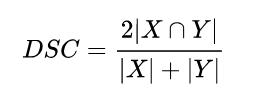

In [ ]:
Image(filename="/content/dice.png")

In [ ]:
! gdown --id 1-6WXJOZAHOuwXw58O2IiQqlj91GiEquC

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-6WXJOZAHOuwXw58O2IiQqlj91GiEquC
To: /content/ARUGD_training_checkpoint.h5
100% 297M/297M [00:01<00:00, 196MB/s]


In [ ]:
from Res_Unet import dice_coef, soft_dice_coef, dice_loss
from keras.models import load_model

model = load_model("ARUGD_training_checkpoint.h5",
                                 custom_objects={"dice_loss": dice_loss,
                                                 "dice_coef": dice_coef,
                                                 "soft_dice_coef": soft_dice_coef})

In [ ]:
img, msk = test_img_datagen.__next__()

In [ ]:
test_prediction = model.predict(img)

1/1 [==============================] - 0s 40ms/step


In [ ]:
print(dice_coef(msk, test_prediction))

tf.Tensor(0.96358603, shape=(), dtype=float32)


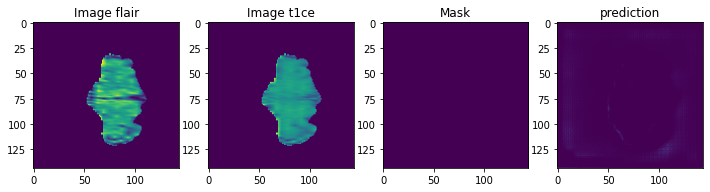

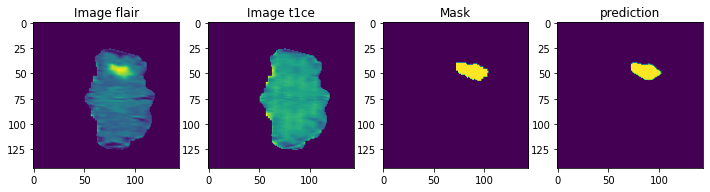

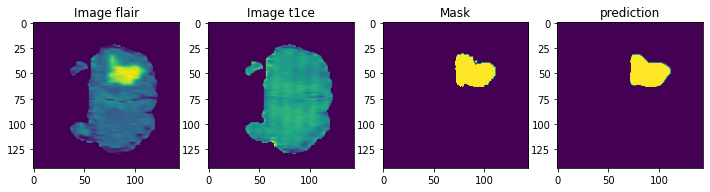

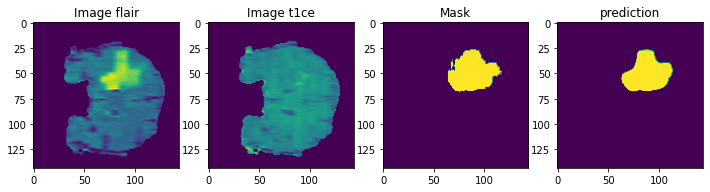

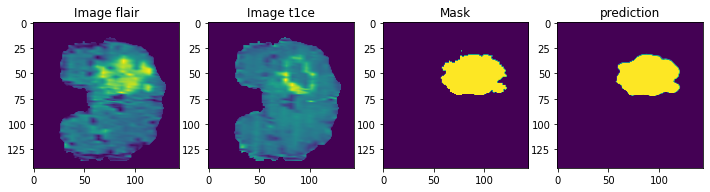

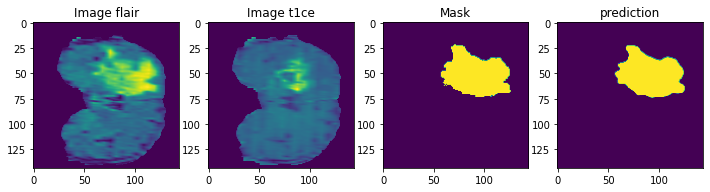

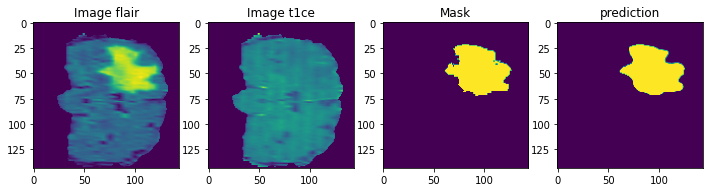

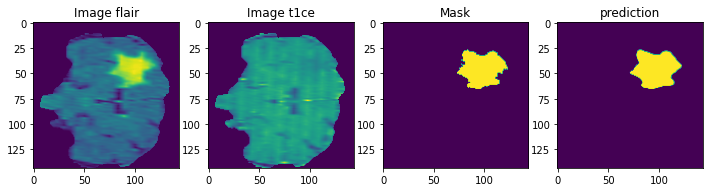

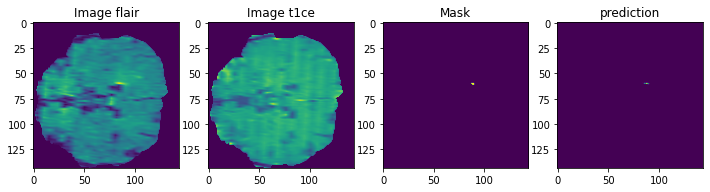

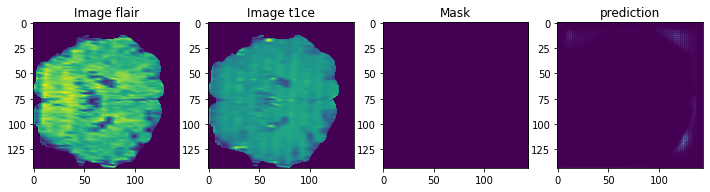

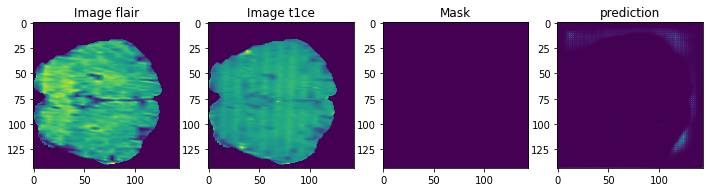

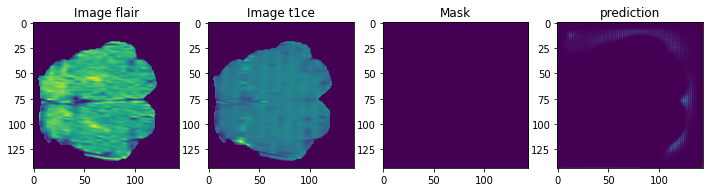

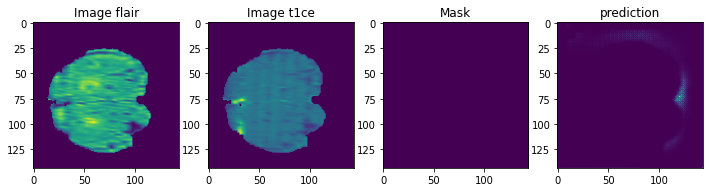

In [ ]:
for i in range(10,140,10):
  n_slice=i
  plt.figure(figsize=(12, 8))

  plt.subplot(141)
  plt.imshow(img[0,n_slice,:,:,0])
  plt.title('Image flair')
  plt.subplot(142)
  plt.imshow(img[0,n_slice,:,:,1])
  plt.title('Image t1ce')
  plt.subplot(143)
  plt.imshow(msk[0,n_slice,:,:,0])
  plt.title('Mask')
  plt.subplot(144)
  plt.imshow(test_prediction[0,n_slice,:,:,0])
  plt.title('prediction')
  plt.show()

In [ ]:
print("\n\nEvaluating best model on the testing dataset.")
print("=============================================")
loss, dice_coef, soft_dice_coef = model.evaluate(test_img_datagen, steps=37)

print("Average Dice Coefficient on testing dataset = {:.4f}".format(dice_coef))



Evaluating best model on the testing dataset.
37/37 [==============================] - 6s 107ms/step - loss: 0.6211 - dice_coef: 0.7816 - soft_dice_coef: 0.7812
Average Dice Coefficient on testing dataset = 0.7816
